## Package imports

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


## Functions needed for cellular automata

**Check neighbours function**

Given the cell matrix and the x,y position; this function returns a grid with the values (1 or 0) of all the neighbouring points to x,y.

In [2]:
def check_neighbours(cell_matrix,y_pos,x_pos): #returns grid with the neighbouring points
    top_array = [cell_matrix[y_pos-1, x_pos-1], cell_matrix[y_pos-1,x_pos], cell_matrix[y_pos-1,x_pos+1]]
    middle_array = [cell_matrix[y_pos, x_pos-1], np.nan, cell_matrix[y_pos,x_pos+1]]
    bottom_array = [cell_matrix[y_pos+1, x_pos-1], cell_matrix[y_pos+1,x_pos], cell_matrix[y_pos+1,x_pos+1]]
    neighbours_cellmatrix = np.array([top_array,middle_array,bottom_array])
    return neighbours_cellmatrix



**Cellular automata singlestep function**

Given the cell matrix and the probability of division at time=t; this function returns the updated cell matrix for time=t+1 and a dictionary of thhe mother/daughter lineage

In [3]:
def cell_automata_singlestep(cell_matrix, p_division):
    daughterToMotherDict = {}
    cell_matrix_new = copy.deepcopy(cell_matrix)

    #Range over all points in the cell matrix except the border points
    for y_pos in np.linspace(1,len(cell_matrix)-2,len(cell_matrix)-2):
        for x_pos in np.linspace(1,len(cell_matrix)-2,len(cell_matrix)-2):
            y_pos = int(y_pos)
            x_pos = int(x_pos)

            # if a point is as cell, check which neighbouring point it could divide into
            if cell_matrix[y_pos, x_pos]!=0:
                neighbours_cellmatrix = check_neighbours(cell_matrix,y_pos,x_pos)

                #if there is an empty cell, decide if the cell will divide depending on the probability p_division
                if 0 in neighbours_cellmatrix:
                    cell_division=np.random.choice([1,0],p=[p_division,1-p_division])
                    if cell_division==1:
                        #choose cell to divide to
                        index_nocells=np.where(np.array(neighbours_cellmatrix )== 0) #find empty cells
                        divided_cell_index = np.random.choice(range(len(index_nocells[0]))) #select empty cell to divide to
                        index_newcell_y, index_newcell_x = (index_nocells[n][divided_cell_index] for n in range(2))
                        
                        #create mask
                        cell_matrix_new[index_newcell_y+y_pos-1,index_newcell_x+x_pos-1]=1

                        #create cellular tissue memory
                        daughterToMotherDict[(index_newcell_y+y_pos-1,index_newcell_x+x_pos-1)] = (y_pos,x_pos)
    return cell_matrix_new, daughterToMotherDict

**Run cellular automata function**

This function runs the cellular automata algorithm for bacterial colony growth over time. 

The result is dependent on the numerical parameters provided: a larger divisionTimeHours means cells will divide less often, meaning slower growth rates. This generates the opposite result to a high p_division.

The results are stored in:
- cell_matrix_record: 3D array with every cell matrix over time.
- daughterToMotherDictList: List of lenght equivalent to the amount of def cell_automata_singlestep computations. Every element of this list is a dictionary where keys are daugther cell positions and values are mother cell positions.



 

In [15]:
def run_cellular_automata(J,dt,N,divisionTimeHours,tqdm_disable=False, p_division=0.3, seed=1):
    #Assume a square as height is same as width
    I=J

    #Define random seed to obtain always the same result with the same seed
    np.random.seed(seed)


    #Define initial cell matrix with a single cell in the middlle.
    #Other initial conditions could be used such as two cells for merging colonies or more complex initial conditions
    cell_matrix = np.zeros(shape=(I,J))
    cell_matrix[int(I/2), int(J/2)] = 1

    #Define cell matrix record. 3D array with cell matrix(J,I) and time (N)
    cell_matrix_record = np.zeros([J, I, N])
    cell_matrix_record[:, :, 0] = cell_matrix 

    #division is not considered at every time step. E.coli's division rate is 1/h so we will consider division every divisionTimeHours.
    divisionTimeUnits=divisionTimeHours/dt 
    divide_counter=0
    daughterToMotherDictList = []

    for ti in tqdm(range(1,N), disable = tqdm_disable):
        daughterToMotherDict = {}

        if (ti%divisionTimeUnits==0): #if it is time to divide
            cell_matrix_new ,daughterToMotherDict = cell_automata_singlestep( cell_matrix, p_division) #compute new cell matrix
            cell_matrix = copy.deepcopy(cell_matrix_new) #update cell matrix
            divide_counter+=1 #update divide counter

        cell_matrix_record[:, :, ti] = cell_matrix  #record cell matrix
        daughterToMotherDictList.append(daughterToMotherDict) #record inheritance in da

    return cell_matrix_record, daughterToMotherDictList


**Plotting functions**
- plot_1D: 1D plot of final timepoint of simulation
- video_1D: time evolution of cellular automata
- plot_growth_curve: diameter of colony over time (represents the same as experimental growth curves)
- plot_volume: gives a 3D view of the colony growth over time

In [30]:
def plot_1D(cell_matrix_record, L, dx):
    plt.imshow(cell_matrix_record[:,:,-1], cmap='Greys')# plot_2D_final_concentration(final_concentration,grids,filename,n_species=n_species)
    tick_positions = np.linspace(0, L/dx, 4)
    tick_labels = np.linspace(0, L, 4).round(decimals=2)
    plt.xticks(tick_positions, tick_labels)
    plt.yticks(tick_positions, tick_labels)
    plt.show()
    plt.close()



def video_1D(cell_matrix_record): #plot the 3D matrix as a video (must save video, otherwise every single timeframe is plotted)
    time=0

    fig = plt.plot()
    rgb_timeseries=cell_matrix_record # Read the numpy matrix with images in the rows
    im=plt.imshow(rgb_timeseries[:,:,0].astype('uint8'), origin= 'lower', cmap='Greys')
    for time in range(len(rgb_timeseries[0,0,:])):
        im.set_data(rgb_timeseries[:,:,time].astype('uint8'))
        
        plt.xlabel(time)
        plt.pause(0.00000000000000001)
    plt.show()


def plot_growth_curve(cell_matrix_record, J, dx, T, dt):      
    lenght_list = []
    for i in range(len(cell_matrix_record[0,0,:])):
        lenght = np.count_nonzero(cell_matrix_record[:,int(J/2),i])
        lenght_list.append(lenght)
    lenght_list = np.array(lenght_list)*dx

    plt.scatter(range(0,N),lenght_list, c='k',s=1)
    plt.xlabel('Time (hours)',fontsize=15)
    plt.ylabel('Colony diameter (mm)', fontsize=15)
    tick_positions = np.linspace(0, T/dt, 4)
    tick_labels = np.linspace(0, T , 4).round(decimals=2)
    plt.xticks(tick_positions, tick_labels,fontsize=15)

    print('y')
    plt.show()


    # %%
def plot_volume(cell_matrix_record):
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    z, x, y = cell_matrix_record.nonzero()
    my_cmap = plt.get_cmap('magma')

    ax.plot_trisurf(z,x,y, linewidth = 100,
                    antialiased = True,alpha=1,cmap=my_cmap)
    ax.set_xlabel('y', labelpad=-10,size=20)
    ax.set_ylabel('x', labelpad=-10,size=20)
    ax.set_zlabel('Time', labelpad=-10,size=20, rotation=90)
    # ax.set_ylabel('Y', rotation=0, labelpad=10)
    color_tuple = (1.0, 1.0, 1.0, 0.0)

    ax.tick_params(color=color_tuple, labelcolor=color_tuple)
    ax.grid(False)
    ax.view_init(20,40, 0)

    plt.show()



## Running cellular automata and plotting results

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:00<00:00, 57.54it/s] 


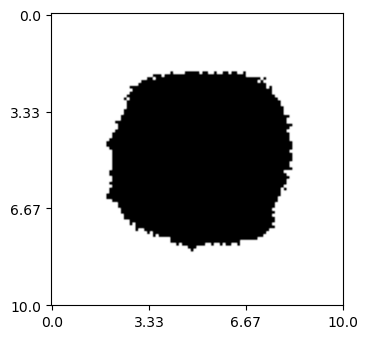

y


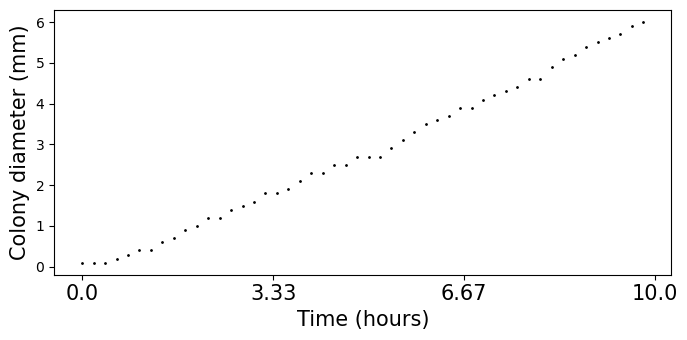

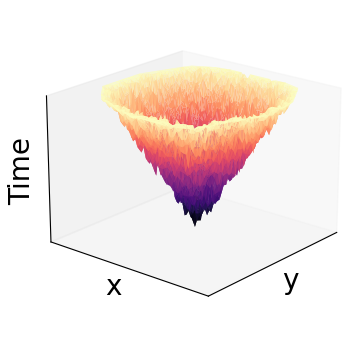

In [31]:
#Numerical parameters
L=10; dx =0.1; J = int(L/dx)
T =10; dt = 0.2; N = int(T/dt)
boundaryCoeff = 1
divisionTimeHours=0.2
p_division=0.7;seed=1

#Execution of cellular automata
cell_matrix_record, daughterToMotherDictList = run_cellular_automata(J,dt,N,divisionTimeHours,tqdm_disable=False,p_division=p_division,seed=seed)

#Plotting results
plot_1D(cell_matrix_record, L, dx)
plot_growth_curve(cell_matrix_record, J, dx, T, dt)
plot_volume(cell_matrix_record)
